In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO: 2016-06-26 10:43:02,157 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
import glob

In [4]:
fns = glob.glob('/artemis/readout/2016-06-25_2[123]*scan_lo*.nc')
fns += glob.glob('/artemis/readout/2016-06-25_205*scan_lo*.nc')
fns += glob.glob('/artemis/readout/2016-06-26_0[012]*scan_lo*.nc')
fns.sort()
print len(fns),fns[0],fns[-1]

100 /artemis/readout/2016-06-25_205408_scan_lo_830.0_MHz.nc /artemis/readout/2016-06-26_021241_scan_lo_1400.0_MHz.nc


In [5]:
import pandas as pd

In [6]:
import joblib


In [7]:
parallel = joblib.Parallel(n_jobs=8,verbose=1)

In [8]:
#@memory.cache
def load_sweep_array(fn):
    ncf = NCFile(fn)
    sa = ncf.SweepArray0
    ncf.close()
    return sa.to_dataframe(one_sweep_per_row=False)

In [9]:
rows = parallel([joblib.parallel.delayed(load_sweep_array)(fn) for fn in fns])

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  4.1min finished


In [10]:
df = pd.concat(rows,ignore_index=True)

In [11]:
df['frequency_MHz'] = df['frequency']/1e6

In [18]:
delta = dB(df.iloc[68].s21_point) -dB(df.iloc[0].s21_point)

<IPython.core.display.Javascript object>


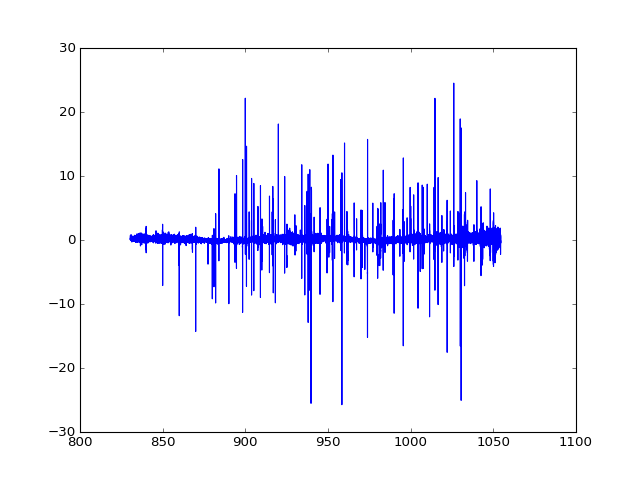

In [19]:
figure()
plot(df.iloc[0].frequency_MHz,delta)

In [15]:
df.shape

(100, 55)

<IPython.core.display.Javascript object>


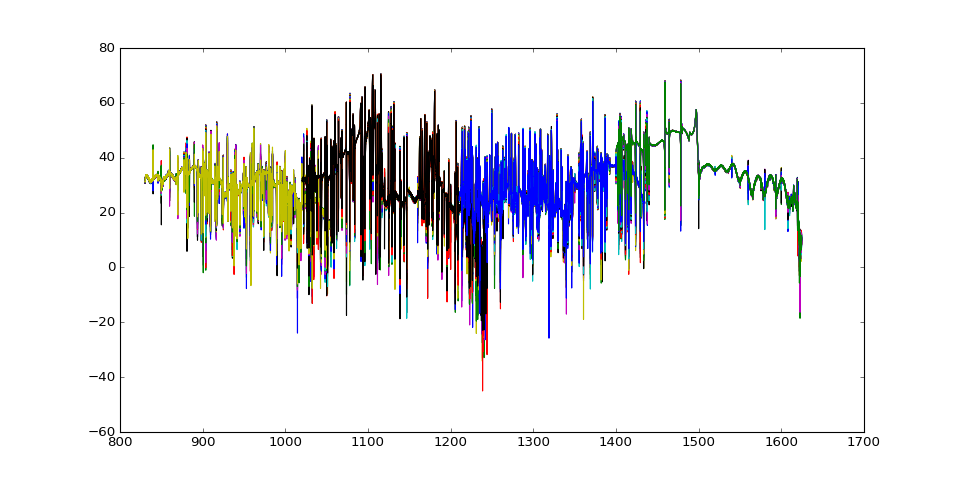

In [17]:
figure(figsize=(12,6))
for k, row in df.iterrows():
    if k < 72:
        plot(row.frequency_MHz,dB(row.s21_point))

In [23]:
25e-6*1000.

0.025

In [15]:
f0s = np.sort(np.load('/artemis/readout/resonances/2016-06-24-jpl-hex-271-all-auto-found-resonators.npy'))

In [16]:
def fit_resonators_in_sweep(df_row,f0s,span=(-400e3,100e3)):
    output = []
    row_freq = df_row.frequency
    max_freq = row_freq.max()
    min_freq = row_freq.min()
    for resonator_index,f0 in enumerate(f0s):
        if (f0 > max_freq-span[1]) or (f0 < min_freq-span[0]):
            continue
        data = dict(resonator_index=resonator_index)
        mask = (row_freq > (f0+span[0])) & (row_freq < (f0+span[1]))
        resonator = lmfit_resonator.LinearResonatorWithCable(row_freq[mask],
                                                             df_row.s21_point[mask],
                                                             df_row.s21_point_error[mask])
        for param in resonator.current_result.params.values():
            data['res_{}'.format(param.name)] = param.value
            data['res_{}_error'.format(param.name)] = param.stderr
        data['res_redchi'] = resonator.current_result.redchi
        data['res_Q_i'] = resonator.Q_i
        data['res_Q_e'] = resonator.Q_e
        data['res_s21_data'] = [resonator.data]
        data['res_frequency_data'] = [resonator.frequency]
        data['res_s21_errors'] = [resonator.errors]
        modelf = np.linspace(resonator.frequency.min(), resonator.frequency.max(), 1000)
        models21 = resonator.model.eval(params=resonator.current_params, f=modelf)
        data['res_model_frequency'] = [modelf]
        data['res_model_s21'] = [models21]

        for param in ['lockin_rms_voltage','heater_voltage']:
            data[param] = df_row[param]
        output.append(pd.DataFrame(data,index=[0]))
    return pd.concat(output,ignore_index=True)

In [17]:
parallel = joblib.Parallel(n_jobs=24,verbose=1)

In [18]:
frames = parallel([joblib.delayed(fit_resonators_in_sweep)(row,f0s) for k,row in df.iterrows()])

[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=24)]: Done  52 out of  52 | elapsed:  1.8min finished


In [19]:
dfres = pd.concat(frames,ignore_index=True)

In [20]:
dfres.shape

(2756, 29)

33


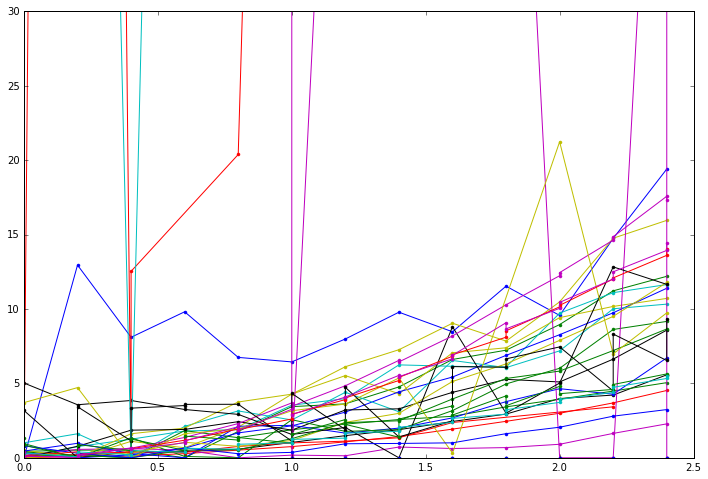

In [24]:
figure(figsize=(12,8))
ngood = 0
for idx in range(177):
    dd = dfres[(dfres.resonator_index==idx) & (dfres.res_redchi < 10) & (dfres.res_Q < 100e3) & (dfres.res_Q_e < 100e3) & (dfres.res_Q > 5e3)]
    if dd.shape[0]>9:
        ngood +=1
        plot(dd.heater_voltage,1e6*(dd.res_f_0.max()-dd.res_f_0)/dd.res_f_0.max(),'.-')
ylim(0,30)
print ngood

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


IndexError: index 32 is out of bounds for axis 0 with size 32

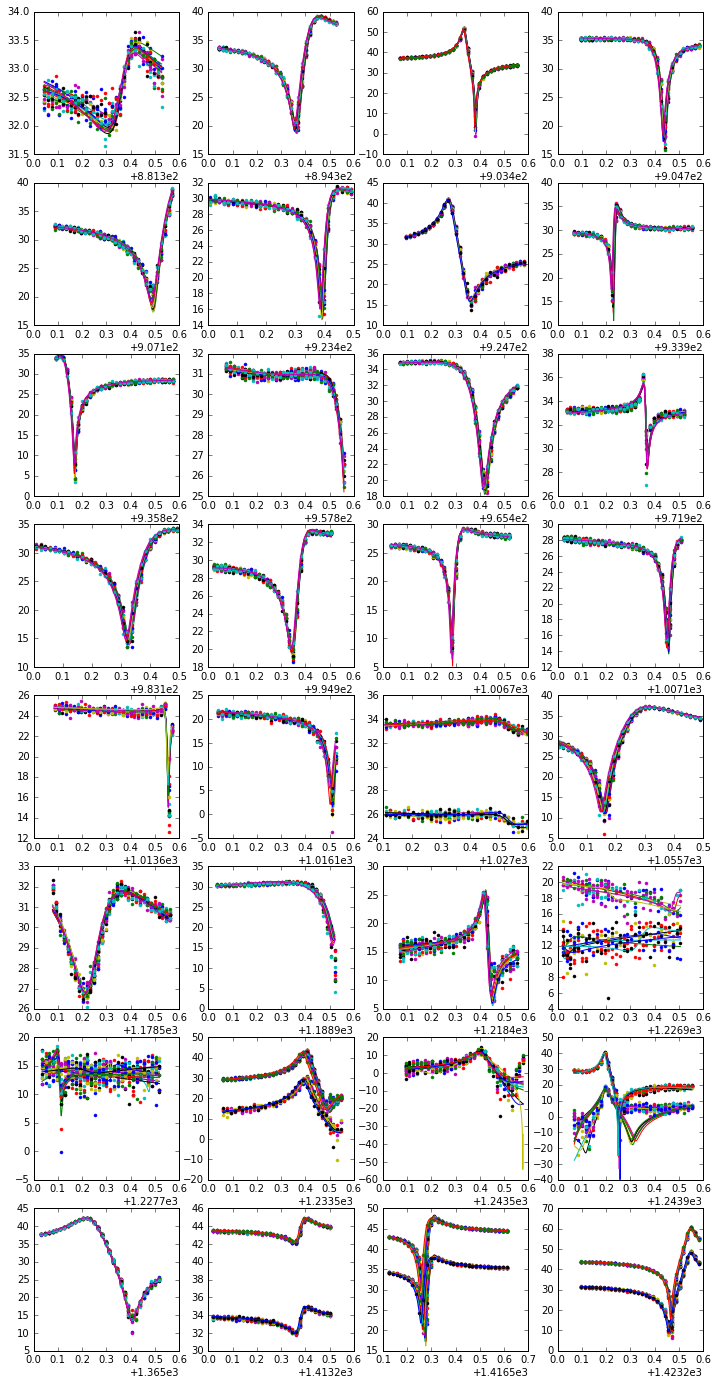

In [23]:
fig,axs = subplots(8,4,figsize=(12,24))
axno = 0
for idx in range(177):
    dd = dfres[(dfres.resonator_index==idx) & (dfres.res_redchi < 10) & (dfres.res_Q < 100e3) & (dfres.res_Q_e < 100e3) & (dfres.res_Q > 5e3)]
    if dd.shape[0]>9:
        ax = axs.flatten()[axno]
        row0 = dd.iloc[0]
        for k,row in dd.iterrows():
            ax.plot(row.res_frequency_data/1e6,dB(row.res_s21_data),'.')
            ax.plot(row.res_model_frequency/1e6,dB(row.res_model_s21))
        axno +=1
